# Interpolation LS Fitting Test
* Constant $k$.
* Discretization: 5-point (4th order).
* Fixed-domain problem; repetitive vs. non-repetitive.

In [259]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Large Aggregate Size

In [331]:
# Fixed seed for reproducible results.
np.random.seed(0)

n = 18
kh = 1.0
a = hm.linalg.helmholtz_1d_operator(kh, n).tocsr()
level = hm.repetitive.hierarchy.create_finest_level(a)

# Generate relaxed test matrix.
num_examples = 16
num_sweeps = 10
level = hm.repetitive.hierarchy.create_finest_level(a)
x = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
b = np.zeros_like(x)
x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)

# Calculate mock cycle predicted efficiency.
aggregate_size_values = np.array([2, 4, 6])
nu_values = np.arange(1, 6, dtype=int)
max_conv_factor = 0.3
coarsener = hm.setup.coarsening_uniform.UniformCoarsener(level, x, aggregate_size_values, nu_values,
                                                         repetitive=True)
r, aggregate_size, nc, _, _, _, _, _, _ = \
    coarsener.get_optimal_coarsening(max_conv_factor)
print(aggregate_size, nc)

4 2


In [332]:
# pd.DataFrame(r.todense())

In [333]:
# R = np.array(r.todense())
# plt.plot(np.arange(4), R[0, :4])
# plt.plot(np.arange(4), R[1, :4]);

In [363]:
p, fit_error, val_error, test_error, alpha_opt = \
    hm.setup.interpolation.create_interpolation_least_squares_domain(
        x, a, r, aggregate_size=aggregate_size, num_components=nc, repetitive=True)
print(fit_error)
print(x.shape)
print("Vector Error", np.mean(norm(x - p.dot(r.dot(x)), axis=1) / norm(x, axis=1)))
print("Point  Error", np.mean(norm(x - p.dot(r.dot(x)), axis=0) / norm(x, axis=0)))

(80, 4) (80, 10)
(80, 4) (80, 10)
[0.223 0.378 0.379 0.287]
(18, 16)
Vector Error 0.31321507485226213
Point  Error 0.3272356799981887


In [364]:
pd.DataFrame(p.todense())

,0,1,2,3,4,5,6,7,8,9
0,0.27,0.16,0.00,0.00,0.00,0.00,0.00,0.00,-0.22,0.10
1,0.42,-0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.03,-0.48,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.31,-0.21,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.22,0.10,0.27,0.16,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.42,-0.23,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.03,-0.48,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,-0.31,-0.21,0.00,0.17,0.00,0.00,0.00,0.00
8,0.00,0.00,-0.22,0.10,0.27,0.16,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.42,-0.23,0.00,0.00,0.00,0.00


In [365]:
p0, fit_error, val_error, test_error, alpha_opt = \
    hm.setup.interpolation.create_interpolation_least_squares_domain(
        x, a, r, aggregate_size=aggregate_size, num_components=nc, repetitive=False)
print(fit_error)
print(x.shape)
print("Vector Error", np.mean(norm(x - p0.dot(r.dot(x)), axis=1) / norm(x, axis=1)))
print("Point  Error", np.mean(norm(x - p0.dot(r.dot(x)), axis=0) / norm(x, axis=0)))

(16, 18) (16, 10)
[0.138 0.063 0.177 0.117 0.071 0.06  0.028 0.058 0.087 0.033 0.067 0.056 0.219 0.044 0.064 0.084 0.07  0.214]
(18, 16)
Vector Error 0.08212109199356303
Point  Error 0.09421237506954204


In [368]:
pd.DataFrame(p0.todense())

,0,1,2,3,4,5,6,7,8,9
0,0.19,0.10,0.00,0.00,0.00,0.00,0.00,0.00,-0.43,0.28
1,0.67,-0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.10,-0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.29,-0.21,0.03,0.31,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.06,-0.06,0.45,0.31,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.61,-0.39,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.16,-0.79,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,-0.37,-0.26,-0.02,0.24,0.00,0.00,0.00,0.00
8,0.00,0.00,-0.38,0.17,0.35,0.15,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.67,-0.42,0.00,0.00,0.00,0.00


In [358]:
pd.DataFrame((p - p0).todense())

,0,1,2,3,4,5,6,7,8,9
0,0.08,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.21,-0.18
1,-0.25,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.06,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.02,0.01,-0.03,-0.14,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.15,0.16,-0.18,-0.15,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,-0.19,0.16,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,-0.13,0.32,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.07,0.05,0.02,-0.07,0.00,0.00,0.00,0.00
8,0.00,0.00,0.16,-0.07,-0.08,0.02,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,-0.24,0.19,0.00,0.00,0.00,0.00


In [367]:
p[17, 9], p0[17, 9], p[17, 9] - p0[17, 9]

(-0.20751579596069147, -0.3955958819962852, 0.18808008603559373)

In [378]:
pd.DataFrame((p != 0).todense().astype(int))

,0,1,2,3,4,5,6,7,8,9
0,1,1,0,0,0,0,0,0,1,1
1,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,0,0,0,0,0,0
6,0,0,1,1,0,0,0,0,0,0
7,0,0,1,1,1,1,0,0,0,0
8,0,0,1,1,1,1,0,0,0,0
9,0,0,0,0,1,1,0,0,0,0


In [377]:
pd.DataFrame(((p0 != 0) != (p != 0)).todense().astype(int))

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


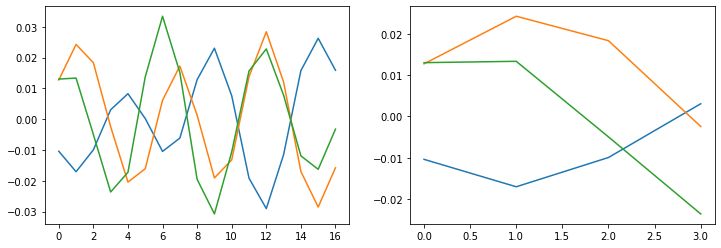

In [254]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
for i in range(3):
    ax.plot(x[:, i])
    
ax = axs[1]
for i in range(3):
    ax.plot(x[:4, i])

In [189]:
svd(x[:, :4])[1]

array([0.192, 0.107, 0.059, 0.043])

In [190]:
nbhr = [np.unique(r[:, a[i].nonzero()[1]].nonzero()[0]) for i in range(x.shape[0])]
print(nbhr)
print(nbhr[:aggregate_size])

[array([0, 1, 8, 9], dtype=int32), array([0, 1], dtype=int32), array([0, 1], dtype=int32), array([0, 1, 2, 3], dtype=int32), array([0, 1, 2, 3], dtype=int32), array([2, 3], dtype=int32), array([2, 3], dtype=int32), array([2, 3, 4, 5], dtype=int32), array([2, 3, 4, 5], dtype=int32), array([4, 5], dtype=int32), array([4, 5], dtype=int32), array([4, 5, 6, 7], dtype=int32), array([4, 5, 6, 7, 8, 9], dtype=int32), array([6, 7, 8, 9], dtype=int32), array([6, 7, 8, 9], dtype=int32), array([6, 7, 8, 9], dtype=int32), array([0, 1, 6, 7, 8, 9], dtype=int32)]
[array([0, 1, 8, 9], dtype=int32), array([0, 1], dtype=int32), array([0, 1], dtype=int32), array([0, 1, 2, 3], dtype=int32)]


In [73]:
max_caliber = 10
xc = r.dot(x)
x_disjoint_aggregate_t, xc_disjoint_aggregate_t = \
    hm.setup.sampling.get_disjoint_windows(x, xc, aggregate_size, nc, max_caliber)
nbhr = nbhr[:aggregate_size]


In [75]:
svd(x_disjoint_aggregate_t[:, :4])[1]

array([0.262, 0.212, 0.066, 0.013])

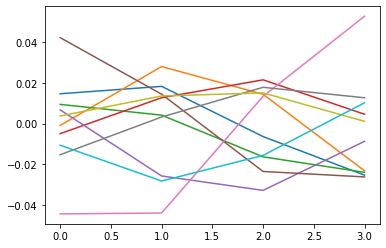

In [101]:
for i in range(10):
    plt.plot(x_disjoint_aggregate_t[i])

In [102]:
num_test_examples = 5
num_examples = x_disjoint_aggregate_t.shape[0]
num_fit_examples = num_examples - num_test_examples
print(x_disjoint_aggregate_t.shape)
fit_samples = int(0.8 * num_fit_examples)
val_samples = int(0.2 * num_fit_examples)
print(fit_samples, val_samples, num_test_examples)

(80, 4)
60 15 5


In [103]:
sklearn.metrics.pairwise.cosine_similarity(x, xc)

array([[-0.934, -0.102, -0.125,  0.694,  0.818,  0.356,  0.169, -0.846],
       [-0.776,  0.63 ,  0.472,  0.524,  0.726, -0.065, -0.553, -0.877],
       [ 0.398,  0.916,  0.523, -0.565, -0.308, -0.161, -0.629,  0.017],
       [ 0.961,  0.142, -0.197, -0.957, -0.807,  0.176,  0.093,  0.667],
       [ 0.552, -0.621, -0.886, -0.454, -0.343,  0.568,  0.596,  0.451],
       [-0.675, -0.603, -0.489,  0.793,  0.749,  0.221,  0.223, -0.462],
       [-0.853, -0.07 ,  0.353,  0.976,  0.757, -0.431, -0.313, -0.546],
       [-0.081,  0.359,  0.954,  0.218, -0.169, -0.917, -0.479,  0.18 ],
       [ 0.806,  0.176,  0.328, -0.788, -0.963, -0.286,  0.102,  0.795],
       [ 0.726, -0.139, -0.473, -0.884, -0.726,  0.559,  0.585,  0.524],
       [-0.364, -0.125, -0.712,  0.063,  0.513,  0.929,  0.369, -0.618],
       [-0.832,  0.217, -0.09 ,  0.665,  0.974,  0.28 , -0.324, -0.965],
       [-0.487,  0.533,  0.525,  0.575,  0.63 , -0.503, -0.899, -0.544],
       [ 0.764,  0.057,  0.353, -0.438, -0.743, -0.

In [104]:
sklearn.metrics.pairwise.cosine_similarity(x_disjoint_aggregate_t.transpose(), xc_disjoint_aggregate_t.transpose())

array([[-0.181, -0.28 , -0.567, -0.137,  0.274,  0.308,  0.533,  0.079],
       [-0.581, -0.426, -0.021,  0.454,  0.611,  0.392, -0.007, -0.396],
       [-0.228, -0.059,  0.478,  0.41 ,  0.177,  0.039, -0.476, -0.341],
       [ 0.364,  0.347,  0.374, -0.132, -0.441, -0.332, -0.363,  0.153]])

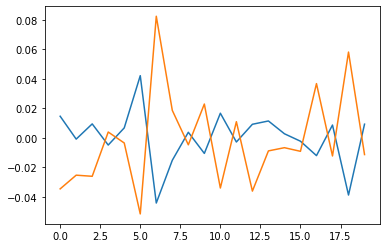

In [105]:
plt.plot(x[0])
plt.plot(xc[0])

In [107]:
domain_size, num_test_functions = x.shape
num_aggregates = int(np.ceil(domain_size / aggregate_size))
num_windows = max(np.minimum(num_aggregates, (12 * max_caliber) // num_test_functions), 1)
num_windows

4

In [169]:
x_disjoint_aggregate_t = np.concatenate(
    tuple(hm.linalg.get_window(x, aggregate_size * offset, aggregate_size)
          for offset in range(num_windows)),
    axis=1).transpose()
print(x_disjoint_aggregate_t.shape)
print(x_disjoint_aggregate_t[:3])

num_coarse_vars = nc * num_aggregates
xc_disjoint_aggregate_t = np.concatenate(tuple(hm.linalg.get_window(xc, offset, num_coarse_vars)
                                               for offset in range(num_windows)), axis=1).transpose()
print(num_coarse_vars, num_windows)
print(xc_disjoint_aggregate_t.shape)
print(xc_disjoint_aggregate_t[:21])

(80, 4)
[[ 0.002 -0.019 -0.024 -0.007]
 [ 0.011  0.024  0.013 -0.006]
 [-0.025  0.004  0.016  0.003]]
8 4
(80, 8)
[[-0.035  0.001  0.003  0.038  0.048 -0.007 -0.016 -0.027]
 [-0.025  0.025  0.053  0.034  0.026 -0.043 -0.041 -0.014]
 [-0.026 -0.014  0.012  0.033  0.018 -0.022 -0.003 -0.003]
 [ 0.004  0.025  0.05  -0.015 -0.028 -0.022 -0.008  0.006]
 [-0.004 -0.043 -0.025  0.015 -0.005  0.003  0.036  0.02 ]
 [-0.052 -0.017 -0.021  0.02   0.043  0.03   0.031 -0.044]
 [ 0.082 -0.005 -0.013 -0.054 -0.067 -0.002  0.005  0.06 ]
 [ 0.019  0.019  0.018 -0.011 -0.01  -0.017 -0.025  0.006]
 [-0.005  0.02   0.018 -0.008 -0.001  0.006 -0.    -0.01 ]
 [ 0.023 -0.027 -0.017 -0.012 -0.035 -0.     0.024  0.035]
 [-0.034 -0.025  0.014  0.029 -0.011 -0.01   0.033  0.012]
 [ 0.011 -0.017  0.004 -0.007 -0.029 -0.003  0.026  0.025]
 [-0.036 -0.012  0.016  0.054  0.04  -0.028 -0.015 -0.008]
 [-0.009  0.025 -0.008 -0.015  0.019  0.028 -0.005 -0.034]
 [-0.007  0.007 -0.002 -0.001  0.002 -0.    -0.009 -0.009]
 

In [151]:
x.shape, xc.shape

((16, 20), (8, 20))

In [168]:
xc[:, 0], xc[:, 1]

(array([-0.035,  0.001,  0.003,  0.038,  0.048, -0.007, -0.016, -0.027]),
 array([-0.025,  0.025,  0.053,  0.034,  0.026, -0.043, -0.041, -0.014]))

In [163]:
x[0:4, 0], x[0:4, 1], x[0:4, -1], x[4:8, 0]

(array([ 0.002, -0.019, -0.024, -0.007]),
 array([ 0.011,  0.024,  0.013, -0.006]),
 array([ 0.012,  0.015,  0.005, -0.005]),
 array([ 0.015,  0.023,  0.01 , -0.008]))

In [164]:
x[0:4, 0], x[0:4, 1], x[0:4, -1], x[4:8, 0]

(array([ 0.002, -0.019, -0.024, -0.007]),
 array([ 0.011,  0.024,  0.013, -0.006]),
 array([ 0.012,  0.015,  0.005, -0.005]),
 array([ 0.015,  0.023,  0.01 , -0.008]))